We are implementing the Levin et al. (2004) colorization algorithm. 

The algorithm operates in $YUV$ space. Where The $Y$ represents the Luminance and the $U$,$V$ are the color channels. In our problem we will receive as the input image only a BW image with the $Y$ channel, and we need to solve the chrominance UV based on a marked image.
Afterwards we will solve a sparse system of linear equations to propagate color from the user scribbles.

Our implementation will use the following libraries:
* `numpy`: Matrix operations.
* `cv2` (OpenCV): Image I/O and RGB $\leftrightarrow$ $YUV$ conversion.
* `scipy.sparse`: Handling the large, sparse affinity matrix.

In [16]:
import numpy as np
import cv2
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

print(f"Numpy: {np.__version__}")
print(f"OpenCV: {cv2.__version__}")

Numpy: 2.2.6
OpenCV: 4.12.0


In the setup phase the images will be loaded and prepared. For this we must first normalize the images by converting them to `float64` in the range `[0, 1]`. This is critical for accurate variance calculations in the weighting function. Then we will convert them to the correct color space $YUV$. The algorithm uses the $Y$ channel from the original image and the $U, V$ values from the scribbles at marked locations.

In [17]:
def load_and_prep(image_path, scribbles_path):
    img_gray_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img_scrib_bgr = cv2.imread(scribbles_path, cv2.IMREAD_COLOR)

    # Normalize
    img_gray = img_gray_bgr.astype(np.float64) / 255.0
    img_scrib = img_scrib_bgr.astype(np.float64) / 255.0

    # Convert to YUV
    img_gray_yuv = cv2.cvtColor(img_gray.astype(np.float32), cv2.COLOR_BGR2YUV)
    img_scrib_yuv = cv2.cvtColor(img_scrib.astype(np.float32), cv2.COLOR_BGR2YUV)

    return img_gray_yuv, img_scrib_yuv

YUV_original, YUV_marked = load_and_prep("example.bmp", "example_marked.bmp")

In [18]:
def show_image(name, image):
    cv2.imshow(name, image)
    cv2.waitKey(0)

    # It is for removing/deleting created GUI window from screen and memory
    cv2.destroyAllWindows()

This is the core of the Levin et al. algorithm. We treat the image as a graph where every pixel is a node connected to its neighbors.

**The Objective:**
We want to minimize the difference between a pixel's color $U(r)$ and the weighted average of its neighbors $U(s)$:
$$J(U) = \sum_{r} \left( U(r) - \sum_{s \in N(r)} w_{rs} U(s) \right)^2$$

The weight $w_{rs}$ represents the similarity between two pixels. If their intensities $Y(r)$ and $Y(s)$ are similar, the weight is large (color propagates). If they are different (an edge), the weight is small.
$$w_{rs} \propto e^{-(Y(r) - Y(s))^2 / 2\sigma_r^2}$$

**The Linear System ($Ax=b$):**
Since the cost function is quadratic, we can solve it by setting the derivative to zero, resulting in a sparse linear system:
1.  **Constrained Pixels (Scribbles):** $U(r) = \text{user\_val}$.
2.  **Unconstrained Pixels:** $U(r) - \sum w_{rs} U(s) = 0$.

In [19]:
def get_weights_and_solve(Y_channel, marked_U, marked_V, mask):
    H, W = Y_channel.shape
    num_pixels = H * W
    
    # Pre-compute indices
    img_indices = np.arange(num_pixels).reshape(H, W)
    mask_flat = mask.flatten()
    
    # Lists for COO construction (using lists of arrays is faster than extending element-wise)
    rows_list = []
    cols_list = []
    data_list = []
    
    # Window offsets (3x3)
    offsets = [(-1, -1), (-1, 0), (-1, 1), 
               (0, -1),           (0, 1), 
               (1, -1),  (1, 0),  (1, 1)]
    
    print("Building affinity matrix (Optimized)...")
    
    # Vectorized neighbor loop
    for dy, dx in offsets:
        # Shift entire image to find neighbors
        # We perform valid slicing to handle borders
        r_slice_y = slice(max(0, -dy), min(H, H - dy))
        r_slice_x = slice(max(0, -dx), min(W, W - dx))
        
        s_slice_y = slice(max(0, dy), min(H, H + dy))
        s_slice_x = slice(max(0, dx), min(W, W + dx))
        
        # Get indices for center (r) and neighbor (s)
        r_idx = img_indices[r_slice_y, r_slice_x].flatten()
        s_idx = img_indices[s_slice_y, s_slice_x].flatten()
        
        # CORE OPTIMIZATION: Filter out constrained pixels immediately.
        # If a pixel is constrained (user scribbled), we don't need its neighbors 
        # because its equation is just U(r) = Value.
        # We only keep 'r' where mask[r] is False.
        active_mask = ~mask_flat[r_idx]
        
        if not np.any(active_mask):
            continue
            
        r_active = r_idx[active_mask]
        s_active = s_idx[active_mask]
        
        # Calculate weights for these active pairs
        Y_r = Y_channel.flatten()[r_active]
        Y_s = Y_channel.flatten()[s_active]
        
        # Weight function
        diff_sq = (Y_r - Y_s) ** 2
        sigma = 0.02
        w_rs = np.exp(-diff_sq / (2 * sigma**2))
        
        rows_list.append(r_active)
        cols_list.append(s_active)
        data_list.append(w_rs)

    # Concatenate all arrays
    rows = np.concatenate(rows_list)
    cols = np.concatenate(cols_list)
    data = np.concatenate(data_list)
    
    # Build Weight Matrix W (N x N)
    # This matrix contains weights ONLY for unconstrained pixels
    W_mat = sparse.csr_matrix((data, (rows, cols)), shape=(num_pixels, num_pixels))
    
    # Normalize W so rows sum to 1
    sum_weights = np.array(W_mat.sum(axis=1)).flatten()
    # Avoid div by zero for constrained pixels (which have sum 0)
    sum_weights[sum_weights == 0] = 1.0 
    D_inv = sparse.diags(1.0 / sum_weights)
    W_norm = D_inv @ W_mat
    
    # Create System Matrix A = I - W
    # For unconstrained: A_row = 1*U(r) - sum(w * U(s))
    # For constrained:   A_row = 1*U(r) - 0             (Identity, since W has 0s there)
    A = sparse.eye(num_pixels, format='csr') - W_norm
    
    # Build RHS vectors (b)
    b_u = np.zeros(num_pixels)
    b_v = np.zeros(num_pixels)
    
    # Enforce constraints: A is already Identity for these rows. 
    # We just set b = User_Value for them.
    # For unconstrained, b = 0.
    b_u[mask_flat] = marked_U.flatten()[mask_flat]
    b_v[mask_flat] = marked_V.flatten()[mask_flat]
    
    print("Solving linear system...")
    final_u = spsolve(A, b_u)
    final_v = spsolve(A, b_v)
    
    return final_u.reshape(H, W), final_v.reshape(H, W)

In [20]:
# Run the solver
# Define mask: where does the scribble image differ from the BW image?
# We look for pixels where color exists (U or V is not 0 or 0.5 depending on range)
# In normalized YUV (0-1), gray is typically around 0.5 for U and V.
# Let's assume significant deviation from the original YUV means a scribble.
diff = np.abs(YUV_marked - YUV_original)
# Sum diff over U and V channels
is_scribbled = (diff[:,:,1] + diff[:,:,2]) > 0.01

print(f"Found {np.sum(is_scribbled)} constrained pixels.")

Found 17405 constrained pixels.


In [21]:
# Solve
solved_u, solved_v = get_weights_and_solve(YUV_original[:,:,0], YUV_marked[:,:,1], YUV_marked[:,:,2], is_scribbled)

Building affinity matrix (Optimized)...
Solving linear system...


Once the solver finishes, we have the optimized $U$ and $V$ channels. We must now:
1.  **Merge Channels:** Stack the original $Y$ (intensity) with the solved $U$ and $V$.
2.  **Convert to RGB:** Transform the YUV image back to RGB space for display.
3.  **Clip Values:** Ensure all pixel values remain within the valid `[0, 1]` range to prevent color artifacts.

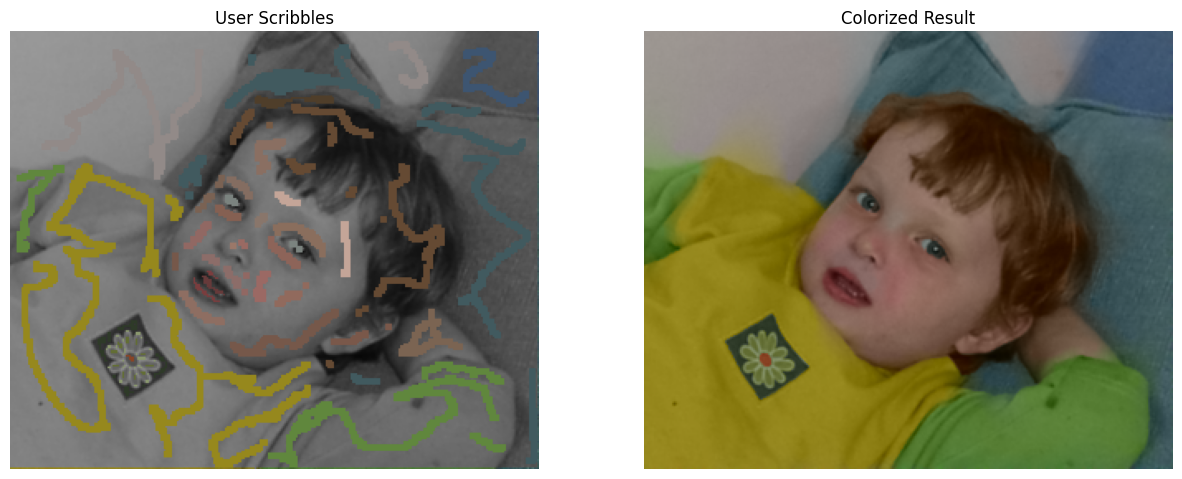

True

In [22]:
def reconstruct_and_show(Y, U, V, original_rgb=None):
    # Stack channels: (H, W) -> (H, W, 3)
    # We use the original Y to preserve detail/texture
    merged_yuv = np.dstack((Y, U, V))
    
    # Convert back to RGB
    # OpenCV expects float32 for color conversion
    merged_yuv = merged_yuv.astype(np.float32)
    converted_rgb = cv2.cvtColor(merged_yuv, cv2.COLOR_YUV2RGB)
    
    # Clip to valid range [0, 1]
    final_image = np.clip(converted_rgb, 0.0, 1.0)
    
    # Display Results
    plt.figure(figsize=(15, 8))
    
    # Show Original Scribbles (if provided)
    if original_rgb is not None:
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(original_rgb, cv2.COLOR_BGR2RGB))
        plt.title("User Scribbles")
        plt.axis('off')

    # Show Result
    plt.subplot(1, 2, 2)
    plt.imshow(final_image)
    plt.title("Colorized Result")
    plt.axis('off')
    
    plt.show()
    
    return final_image

# Reconstruct using the Y from the original grayscale and the U/V we just solved
# Note: We load the original scribble image just for visualization purposes
scribble_bgr = cv2.imread("example_marked.bmp") # Reload for display

final_img = reconstruct_and_show(
    YUV_original[:,:,0], # Original Intensity
    solved_u,            # Solved Color U
    solved_v,            # Solved Color V
    scribble_bgr         # For side-by-side comparison
)

# Optional: Save the output
# Convert RGB back to BGR for OpenCV saving and scale to 0-255
save_img = (cv2.cvtColor(final_img, cv2.COLOR_RGB2BGR) * 255).astype(np.uint8)
cv2.imwrite("colorized_output.png", save_img)